In [29]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

In [30]:
car_images = glob.glob('train/vehicles/**/*.png')
noncar_images = glob.glob('train/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


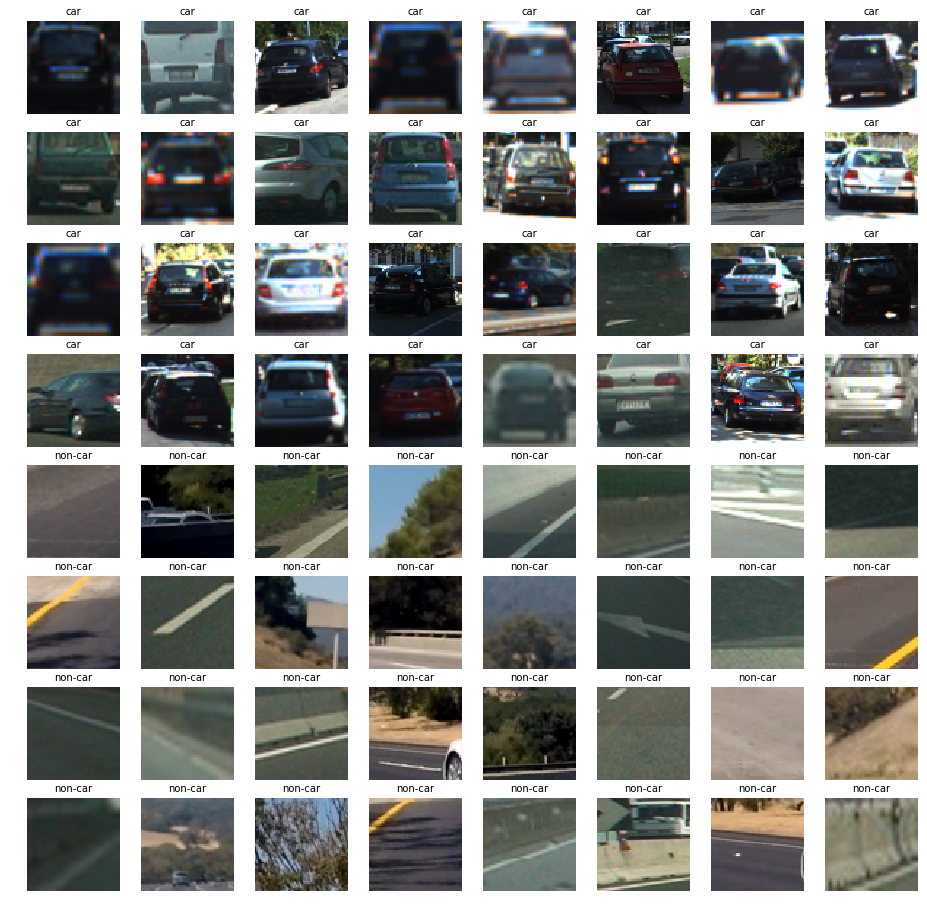

In [88]:
fig, axs = plt.subplots(8, 8, figsize=(16, 16))
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0, len(car_images))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32, 64):
    img = cv2.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non-car', fontsize=10)
    axs[i].imshow(img)

In [95]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, visualize=False, feature_vec=True):
    """
    Extract HOG features from image
    """
    # Call with two outputs if vis==True
    if visualize:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=visualize, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=visualize, feature_vector=feature_vec)
        return features

...


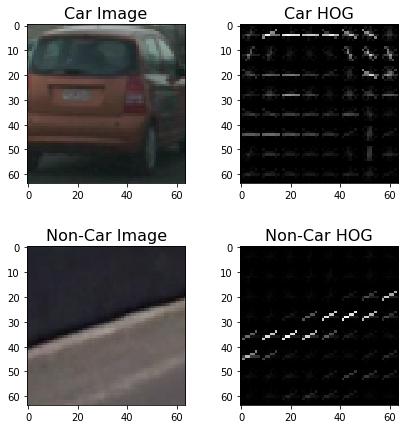

In [269]:
# Visualize result of HOG feature extraction

car_img = mpimg.imread(car_images[10])
_, car_dst = get_hog_features(car_img[:, :, 2], 9, 8, 8, visualize=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[10])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, visualize=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

In [270]:
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """
    Function to extract features from a list of image locations
    This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
    flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
    to be used together for classification
    
    Parameters
    ----------
    imgs: list of str. list of image paths
    cspace: str specifying color space. Can be one of the following:
        RGB, HSV, LUV, HLS, YUV, YCrCb
    orient: int. number of orientations
    pix_per_cell: int. 
    cell_per_block: 2.
    hog_channel: hog channel. can be one of the following:
        0, 1, 2, 'ALL'
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    rgb_dict = {
        'HSV': cv2.COLOR_RGB2HSV,
        'LUV': cv2.COLOR_RGB2LUV,
        'HLS': cv2.COLOR_RGB2HLS,
        'YUV': cv2.COLOR_RGB2YUV,
        'YCrCb': cv2.COLOR_RGB2YCrCb
        
    }
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = cv2.cvtColor(image, rgb_dict[cspace])

        else: 
            feature_image = np.copy(image)      

        # Call get_hog_features() with visualize=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    visualize=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient, 
                        pix_per_cell, cell_per_block, visualize=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

print('...')

...


In [306]:
# Feature extraction parameters
colorspace = 'LUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

29.96 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [307]:
def build_classifier(model_cls, **kwargs):
    model = model_cls(**kwargs)
    model_name = model.__class__.__name__
    # Check the training time for the random forest
    t = time.time()
    model.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train {}...'.format(model_name))
    # Check the score of the logistic regression
    print('Train Accuracy = ', round(model.score(X_train, y_train), 4))
    print('Test Accuracy =',round(model.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My predicts: ', model.predict(X_test[0 : n_predict]))
    print('For these', n_predict, 'labels: ', y_test[0 : n_predict])
    t2 = time.time()
    print(round(t2 - t, 5), 'Seconds to predict', n_predict)
    print('---------------------------------------------------')
    
    return model

In [308]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

lr = build_classifier(LogisticRegression)
svc = build_classifier(LinearSVC)
rf = build_classifier(RandomForestClassifier)
gbm = build_classifier(GradientBoostingClassifier)

1.95 Seconds to train LogisticRegression...
Train Accuracy =  0.969
Test Accuracy = 0.9628
My predicts:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
For these 10 labels:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
0.00067 Seconds to predict 10
---------------------------------------------------
0.78 Seconds to train LinearSVC...
Train Accuracy =  0.9805
Test Accuracy = 0.9733
My predicts:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
For these 10 labels:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
0.00057 Seconds to predict 10
---------------------------------------------------
3.18 Seconds to train RandomForestClassifier...
Train Accuracy =  0.9992
Test Accuracy = 0.9583
My predicts:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
For these 10 labels:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
0.00137 Seconds to predict 10
---------------------------------------------------
122.5 Seconds to train GradientBoostingClassifier...
Train Accuracy =  0.9911
Test Accuracy = 0.9792
My predicts:  [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
For these 10 labels:  [0. 0. 0. 0. 0.

In [278]:

def find_cars(img, ystart, ystop, scale, cspace, hog_channel, model, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    """
    Define a single function that can extract features using hog sub-sampling and make predictions
    """
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop, :, :]

    # apply color conversion if other than 'RGB'
    rgb_dict = {
        'HSV': cv2.COLOR_RGB2HSV,
        'LUV': cv2.COLOR_RGB2LUV,
        'HLS': cv2.COLOR_RGB2HLS,
        'YUV': cv2.COLOR_RGB2YUV,
        'YCrCb': cv2.COLOR_RGB2YCrCb
        
    }
    if cspace != 'RGB':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, rgb_dict[cspace])
    else: 
        ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]
    else:
        ch1 = ctrans_tosearch[:, :, hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1  #-1 
    nfeat_per_block = orient * cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos : ypos+nblocks_per_window, xpos : xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = model.predict(test_features)
            
            ######################################################################
            features = hog_features.reshape((1, -1))
#             print(features.shape)
            test_prediction = model.predict(features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                rectangles.append(((xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                
    return rectangles
    
print('...')

...


In [279]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
model = svc

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

6 rectangles found in image


In [280]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


...


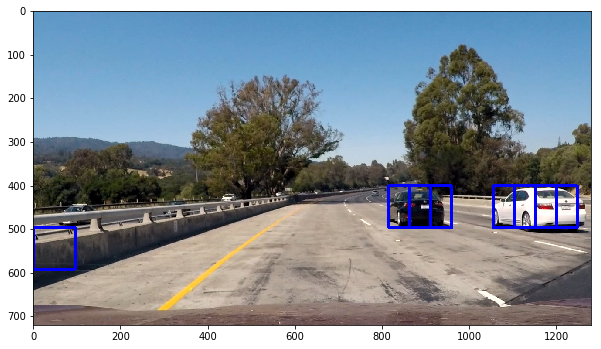

In [281]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

Number of boxes:  78


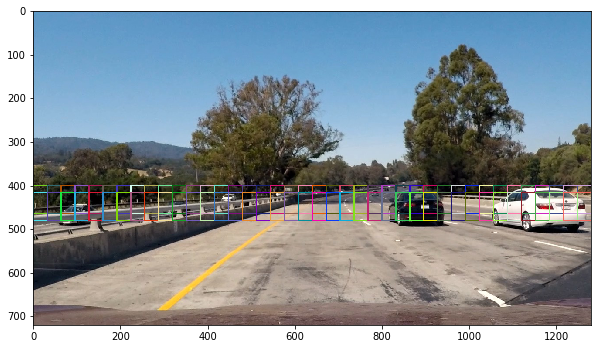

In [282]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))


Number of boxes:  50


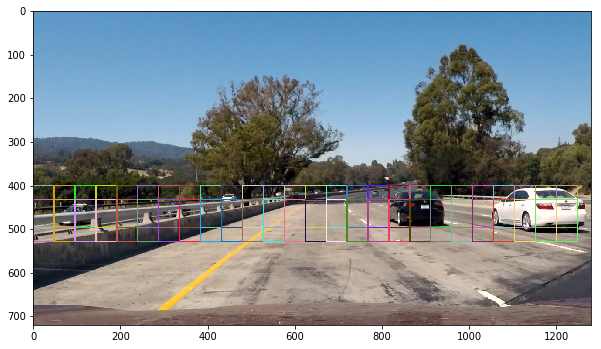

In [283]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  38


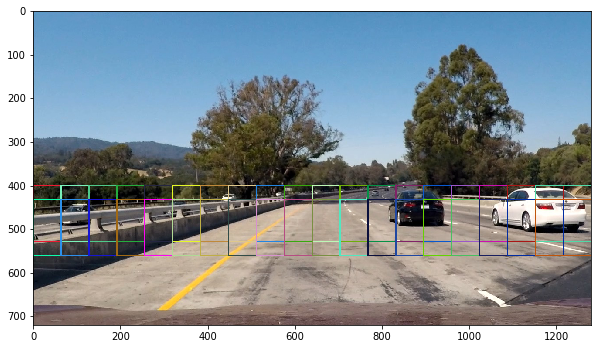

In [284]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


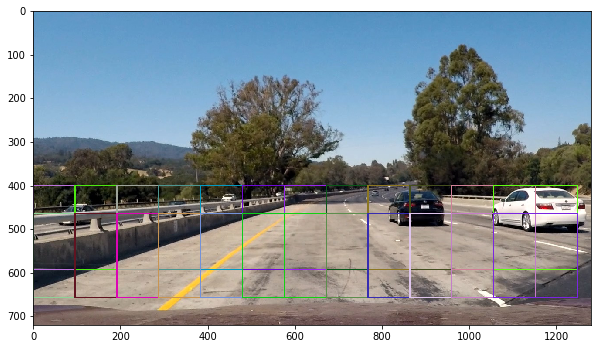

In [285]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

...


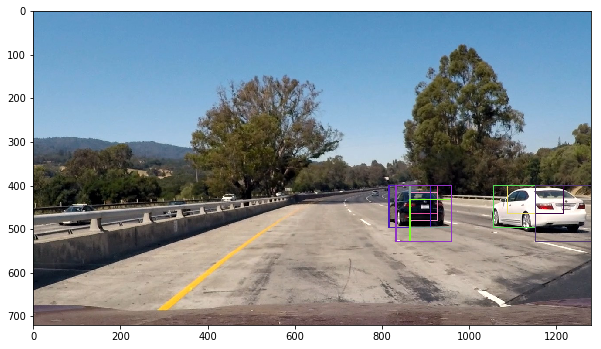

In [286]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

In [287]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')

...


...


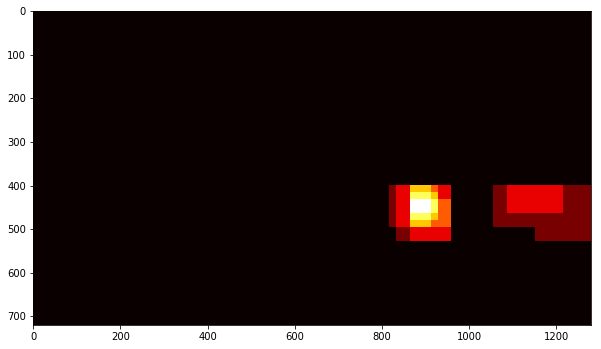

In [288]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

In [289]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('...')

...


...


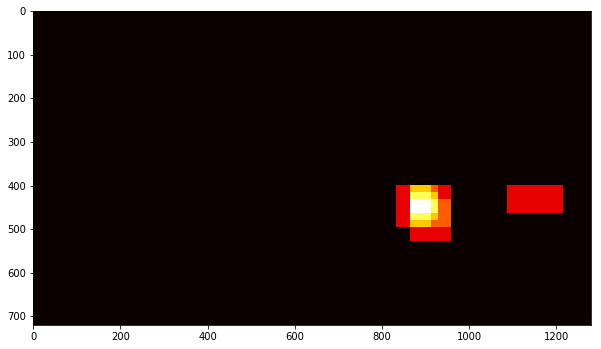

In [290]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

2 cars found


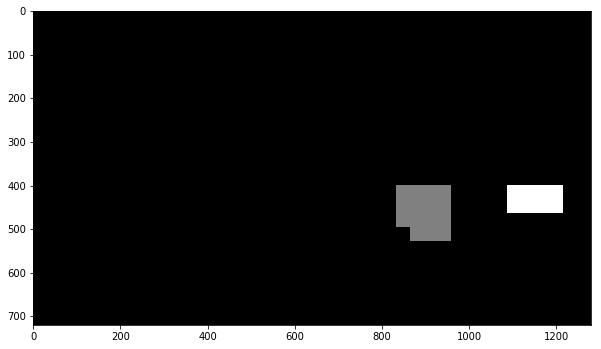

In [291]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

...


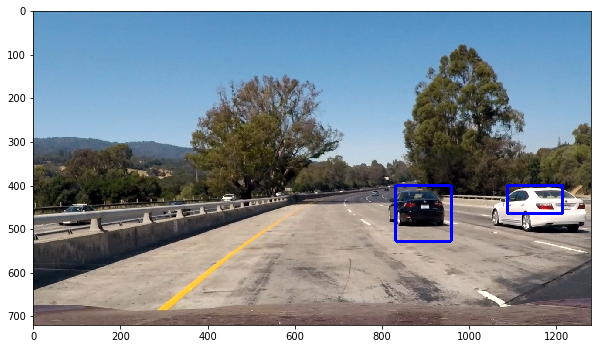

In [292]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

In [293]:
def process_frame(img):

    rectangles = []

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

...


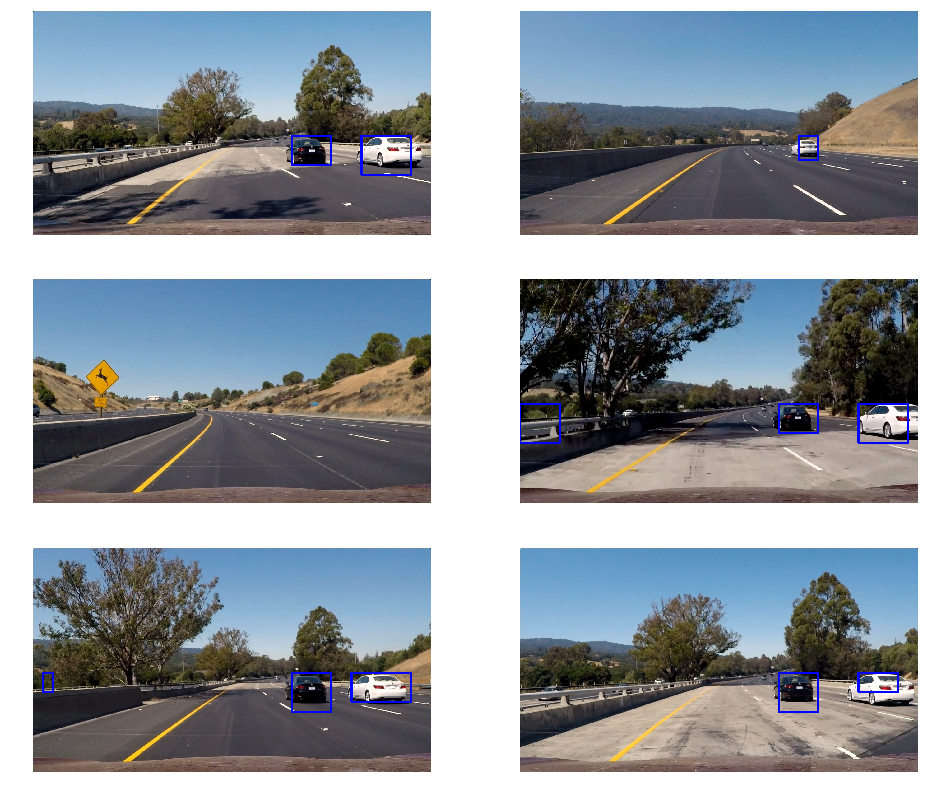

In [294]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [295]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:07<00:00,  5.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 44.5 s, sys: 1.56 s, total: 46.1 s
Wall time: 7.47 s


In [262]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [296]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('...')

...


In [297]:
def process_frame_for_video(img, model=svc):

    rectangles = []

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

...


In [298]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:07<00:00,  5.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 44.7 s, sys: 1.63 s, total: 46.3 s
Wall time: 7.53 s


In [299]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

In [300]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:55<00:00,  5.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 24min 10s, sys: 52.2 s, total: 25min 2s
Wall time: 3min 55s


In [305]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))